# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

# Решение

Загрузите набор данных *data.adult.csv* с помощью `pandas` (скачать можно [здесь](https://drive.google.com/file/d/1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf/view?usp=sharing), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

#### Import

In [56]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # yeah, sure buddy

In [57]:
import pandas as pd
import numpy as np
import sklearn as skl
import imblearn as imb

from collections import Counter

Для работы будем использовать основные метрики: `balanced_accuracy` и `f1`. У нас несбалансированная выборка (о чем можно узнать по ссылке в введении, а также в анализе датасета ниже), поэтому `accuracy` не подойдет для корректной оценки классификатора. В свою очередь `f1` укажет на ошибки I и II рода.

>`precision` и `recall` используются как второстепенные метрики, т.к. "входят" в метрику `f1`.

In [58]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, recall_score

# Просмотр результатов
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Ключевые модели: `DecisionTreeClassifier` и `KNeighborsClassifier`. Еще попробуем обучить и протестировать `CatBoost`, который создан для датасета с категориальными признаками:

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn.base import clone

Кросс-валидацию для поиска оптимальных параметров будем искать путем `GridSearchCV`, также настроим параметры кросс-валидации через `StratifiedKFold`:

In [60]:
from sklearn.model_selection import GridSearchCV # для поиска оптимальных гиперпараметров
from sklearn.model_selection import StratifiedKFold # для лучшего контроля кросс-валидации

from sklearn.model_selection import cross_val_score

Препроцессинг, трансформация и разбиение данных:

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

>Еще были сделаны шаги для балансирования целевых лейблов методом `NeighbourhoodCleaningRule` ([подробнее](#balancing_classes)):

In [62]:
# Undersampling
from imblearn.under_sampling import NeighbourhoodCleaningRule

Визуализация:

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from scikitplot.metrics import plot_roc


from sklearn import tree # для демонстрации: как устроено дерево

In [64]:
RANDOM_STATE = 42

#### Технические функции

In [65]:
target_classes = ['>50K', '<=50K']
cross_validation = StratifiedKFold(n_splits=5, shuffle=False)
grid_search_scoring = ['balanced_accuracy', 'precision', 'recall', 'f1_macro']

color_sns = 'YlOrBr'

In [66]:
def plot_confusionmatrix(y_train_pred, y_train, dom):
  """Функция строит матрицу конфузии для бинарной классификации

  Arguments:
    y_train_pred: вектор предсказанных данных на датасете размером (n_features, 1);
    y_train: вектор исходных таргет-данных на датасете размером (n_features, 1);
    dom: описание
  """

  print(f'Матрица конфузии на {dom} выборке')
  cf = confusion_matrix(y_train_pred, y_train)
  sns.heatmap(cf,
              annot=True,
              yticklabels=target_classes,
              xticklabels=target_classes,
              cmap=color_sns,
              fmt='g')
  plt.tight_layout()
  plt.show()

In [67]:
def create_plot_data(clf_gridsearch, x_col="param_n_estimators"):
  """Парсит словарь GridSearchCV в данные для графика

  Arguments:
    clft_gridsearch: обученный класс GridSearchCV
    x_col: столбец значений признака для исследования

  Returns:
    tuple object: (X, y_accuracy_score, y_f1_score) одинакового размера (index=0)
  """

  clf_pd = pd.DataFrame(clf_gridsearch.cv_results_)
  clf_pd_subdata = clf_pd[[x_col, "mean_test_balanced_accuracy", "mean_test_f1_macro"]]
  clf_pd_subdata.sort_values(by=[x_col])
  clf_pd_subdata_data = clf_pd_subdata.values.tolist()

  clf_pd_subdata_data_X = []
  clf_pd_subdata_data_Y = [[], []]

  for elem in clf_pd_subdata_data:
    clf_pd_subdata_data_X.append(elem[0])
    clf_pd_subdata_data_Y[0].append(elem[1]) #accuracy
    clf_pd_subdata_data_Y[1].append(elem[2]) #f1_score

  return(clf_pd_subdata_data_X, clf_pd_subdata_data_Y)

In [68]:
def plot_GSCV_score(grid_search, plt_label_x, plt_title, metric='f1_score', x_col="param_max_depth"):
    """Создает график изменения точности модели от изменяемых параметрах в GridSearchCV по метрике f1

    Arguments:
      grid_search: обученный класс GridSearchCV
      plt_label_x: описание для оси ординат
      plt_title: титульник графика
      metric: метрика для исследования
      x_col: столбец значений признака для исследования
    
    """

    # Выбор метрики
    if metric == 'f1_score':
        metric_idx = 1
        metric_dict = 'mean_test_f1_macro'
        metric_label = "f1 score"
    elif metric == 'balanced_accuracy':
        metric_idx = 0
        metric_dict = 'mean_test_balanced_accuracy'
        metric_label = "Balanced accuracy score"
    else:
        raise TypeError("Unknown metric")

    # Обработка значений
    (X_plot, Y_plot) = create_plot_data(grid_search, x_col)

    CI = 1.96 * np.std(Y_plot[metric_idx])/np.sqrt(len(Y_plot[metric_idx]))

    ymin = min(grid_search.cv_results_[metric_dict]) -0.1
    ymax = max(grid_search.cv_results_[metric_dict]) +0.1

    # Создание графика
    fig, ax = plt.subplots()
    
    ax.plot(X_plot, Y_plot[metric_idx], label='F1 score', color='g')
    ax.fill_between(X_plot, (Y_plot[metric_idx]-CI), (Y_plot[metric_idx]+CI), color='g', alpha=.1)

    ax.set(xlabel=plt_label_x, ylabel=metric_label, title=plt_title, ylim=(ymin, ymax))
    ax.grid()
    ax.legend()

    plt.show()

#### Загрузка датасета

In [69]:
dataset_pd = pd.read_csv('data_adult.csv', delimiter=',')
dataset_pd.head(20)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


Заменим в задаче бинарной классификации целевую переменную на 1 и 0:

In [70]:
target_to_replace = dataset_pd[">50K,<=50K"].unique()
dataset_pd[">50K,<=50K"].replace(to_replace=target_to_replace[0], value=0, inplace=True)
dataset_pd[">50K,<=50K"].replace(to_replace=target_to_replace[1], value=1, inplace=True)

In [71]:
dataset_pd.shape

(16280, 14)

In [72]:
dataset_pd.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
count,16280.000000,1.628000e+04,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000
mean,38.635074,1.894594e+05,10.098219,1020.417752,86.696314,40.403686,0.247912
std,13.635301,1.066644e+05,2.567690,6862.041550,402.308715,12.341191,0.431813
min,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.170068e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781340e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.371630e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).


In [73]:
dataset_pd = dataset_pd.mask(dataset_pd == '?')
dataset_pd.dropna(inplace=True)
dataset_pd.drop_duplicates(inplace=True)
dataset_pd.shape

(15335, 14)

In [74]:
data = dataset_pd.drop(['>50K,<=50K'], axis=1)
target = dataset_pd['>50K,<=50K']

Нужно применить кодировку категориальных данных. Кодировка `ordinal encoding (OE)` подходит по смыслу только для признака `education`, но в датасете уже существует `education-num`. Так что используем по умолчанию `one-hot enconding (OHE)`.

In [75]:
dataset_pd.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,0
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,0
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,0
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,0
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,1


In [76]:
# Категориальные: 
cat_cols = ["workclass",
            "education",
            "marital-status",
            "occupation",
            "relationship",
            "race",
            "sex",
            ]

# Числовые:
num_cols = ["age",
            "fnlwgt",
            "education-num",
            "capital-gain",
            "capital-loss",
            "hours-per-week"]

for feature_val in cat_cols:
    print(f"{feature_val}: \t{dataset_pd[feature_val].unique()}\n")

workclass: 	['Local-gov' 'Private' 'Federal-gov' 'Self-emp-inc' 'State-gov'
 'Self-emp-not-inc' 'Without-pay']

education: 	['HS-grad' 'Some-college' 'Bachelors' 'Assoc-acdm' '12th' 'Doctorate'
 '1st-4th' '7th-8th' 'Masters' '5th-6th' '11th' '9th' 'Assoc-voc'
 'Prof-school' '10th' 'Preschool']

marital-status: 	['Never-married' 'Divorced' 'Married-civ-spouse' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse' 'Widowed']

occupation: 	['Farming-fishing' 'Sales' 'Prof-specialty' 'Tech-support' 'Adm-clerical'
 'Other-service' 'Machine-op-inspct' 'Protective-serv' 'Transport-moving'
 'Exec-managerial' 'Craft-repair' 'Handlers-cleaners' 'Priv-house-serv'
 'Armed-Forces']

relationship: 	['Not-in-family' 'Own-child' 'Husband' 'Unmarried' 'Wife' 'Other-relative']

race: 	['Black' 'White' 'Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Other']

sex: 	['Male' 'Female']



При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? В каком диапазоне лежат исследуемые признаки?

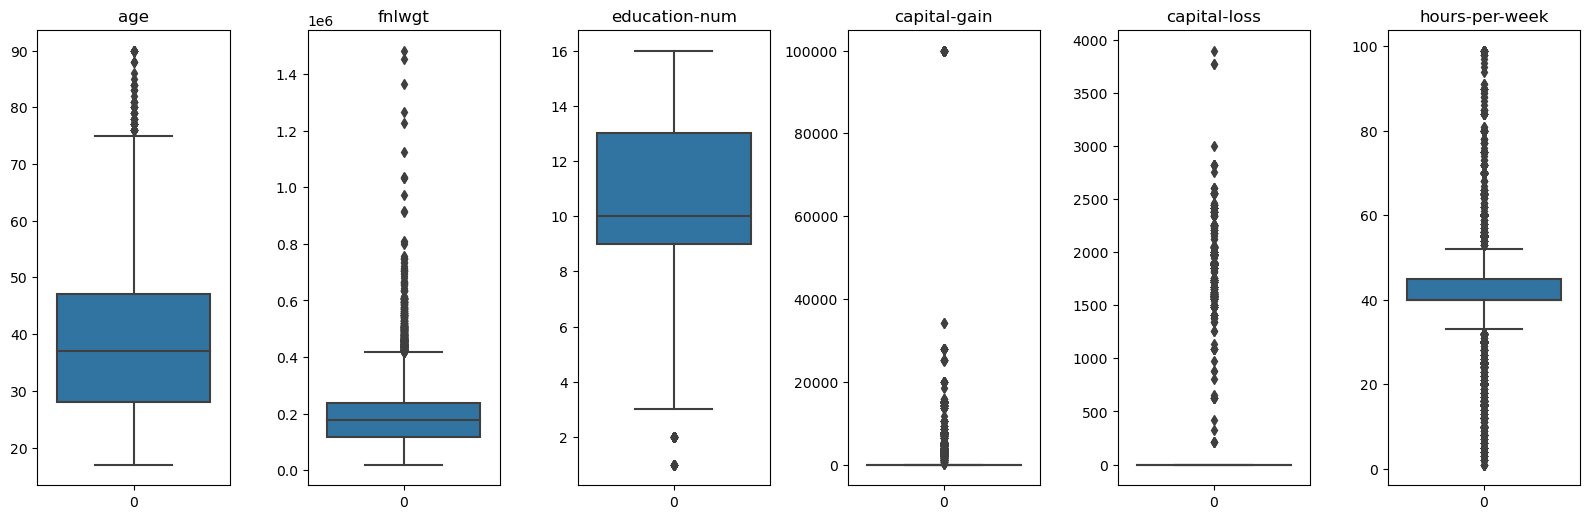

In [77]:
# Категориальные данные
plt.figure(figsize=(16,10))
for i,col in enumerate(num_cols):    
    plt.subplot(2,6,i + 1)
    ax = sns.boxplot(data=data[col])
    ax.set_title(col)

plt.tight_layout()
plt.show()

Важное замечание: `sns.boxplot` отмечает выбросы данных как черный ромб. Это выбросы по определению, совсем не значит, что от них стоит избавляться. Но по определению $IQR$ можно сделать вывод, что в выборке очень много людей с нулевым значением признаков `capital-gain` и `capital-loss`. Информация о датасете довольно поверхностная, поэтому я не могу сделать вывод что делать с этими признаками. Оставляем.

In [78]:
# Численные данные
num_all = data.shape[0]

for i, col in enumerate(cat_cols):
    print(data[col].value_counts(normalize=True))
    print('\n')

workclass
Private             0.734920
Self-emp-not-inc    0.086338
Local-gov           0.069579
State-gov           0.042061
Self-emp-inc        0.036583
Federal-gov         0.030062
Without-pay         0.000456
Name: proportion, dtype: float64


education
HS-grad         0.322726
Some-college    0.220802
Bachelors       0.168569
Masters         0.055950
Assoc-voc       0.045321
11th            0.034170
Assoc-acdm      0.033192
10th            0.026541
Prof-school     0.018911
7th-8th         0.018846
9th             0.015194
Doctorate       0.012520
12th            0.012129
5th-6th         0.009260
1st-4th         0.004304
Preschool       0.001565
Name: proportion, dtype: float64


marital-status
Married-civ-spouse       0.471992
Never-married            0.319661
Divorced                 0.135507
Separated                0.032279
Widowed                  0.027519
Married-spouse-absent    0.012390
Married-AF-spouse        0.000652
Name: proportion, dtype: float64


occupation
Prof-spe

Не будем убирать выбросы данных, хотя хорошие кандидаты неа удаление это объекты с признаком `education: {"Preschool", "1st-4th", "5th-6th"}`. Логично предположить, что для таких людей целевая переменная должна быть `<50`, иначе же такой объект - явно выброс. 

In [79]:
unique, counts = np.unique(target, return_counts=True)
dict(zip(unique, counts))

{0: 11396, 1: 3939}

Выборка не сбалансирована, о чем сказано на странице датасета. Из-за этого можно ожидать, что Решающее дерево покажет себя хуже, чем kNN.

Дерево строит разделяющую поверхность согласно критерию и разделяет какое-то количество образцов в один лист (узел). С этой точки зрения kNN может смотреться выгоднее, но если редковстречающийся класс находится в одной области в пространстве признаков, эффективность Дерева может сравняться с kNN.

Боремся с балансировкой классов, согласно __[результатам из Варианта 2](https://github.com/masl3noki/course-ML/tree/main/Lab2_complex_task_var2)__.

## Трансформация данных

In [80]:
dataset_pd.columns.to_list()

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 '>50K,<=50K']

In [81]:
columns_to_scale  = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'] #[0, 1, 2, 3, 4, 5]
columns_to_encode = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

### Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

In [82]:
ohe = skl.preprocessing.OneHotEncoder()

encoded_cols = ohe.fit_transform(data[columns_to_encode]).toarray()

In [83]:
print(f"Размер матрицы признаков до OHE: {data[columns_to_encode].shape[1]}   \nРазмер матрицы признаков после OHE: {encoded_cols.shape[1]}")

Размер матрицы признаков до OHE: 7   
Размер матрицы признаков после OHE: 57


### Скейлинг и конкатенация трансформированных участков датасета

Скейлинг данных это проекция непрерывных величин на какой-то другой интервал путем, например, следующего преобразования: $$x' = \frac{x-\mu}{\sigma}$$ 

В случае с категориальными данными скейлинг не допустим, т.к. даже после кодировки, в признаке остаются дискретные значения. 

Будем использовать `StandartScaler`, т.к. найденные выбросы данных (согласно `boxplot`) не являются таковыми. Как альтернатива можно использовать `RobustScaler`.


In [84]:
scaler = StandardScaler()

scaled_cols = scaler.fit_transform(data[columns_to_scale])

In [85]:
data_processed = np.concatenate([scaled_cols, encoded_cols], axis=1)

print(f"Размер матрицы признаков до трансформации: {data.shape} = {data[columns_to_scale].shape} + {data[columns_to_encode].shape}")
print(f"Размер матрицы признаков после трансформации: {data_processed.shape} = {scaled_cols.shape} + {encoded_cols.shape}")

Размер матрицы признаков до трансформации: (15335, 13) = (15335, 6) + (15335, 7)
Размер матрицы признаков после трансформации: (15335, 63) = (15335, 6) + (15335, 57)


Выделим из `X_train` датасет для валидации, не трогая `X_test`

In [86]:
X_train, X_test, y_train, y_test = train_test_split(data_processed, target, train_size=0.6, random_state=RANDOM_STATE) # Train/Test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=RANDOM_STATE) # Train/Val split
print(f"Train dataset: {X_train.shape, y_train.shape}; \nValidation dataset: {X_val.shape, y_val.shape}; \nTest dataset: {X_test.shape, y_test.shape}")

Train dataset: ((6440, 63), (6440,)); 
Validation dataset: ((2761, 63), (2761,)); 
Test dataset: ((6134, 63), (6134,))


### Балансировка классов

<a id='balancing_classes'></a>

>Подробное исследование балансировок на данном датасете __[можно найти здесь](https://github.com/masl3noki/course-ML/tree/main/Lab2_complex_task_var2)__

В __[источнике датасета](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)__ указано, что присутствует дисбаланс классов: $\approx 25\% /75\%$ (что мы и наблюдаем выше). Назовем редковстречающийся класс *негативным*, а другой - *позитивным* и попробуем решить эту проблему методом `Neighborhood Cleaning Rule`.

In [88]:
ncr = NeighbourhoodCleaningRule()

`Neighborhood Cleaning Rule` - балансировка целевых лейблов, которая действует по следующему принципу: 

Пусть: 
    
* Множество $A$ - исходная train-выборка;
* Множество $B$ содержит все `1`-классы (позитивные). $B$ постоянен относительно $A$;

Алгоритм:

* Согласно классификатору `ENN` создается множество $\sigma_1 \in A$. Этот шаг выделяет зашумленные данные в $A$;
* Аналогично отбираются данные внутри множества $B$: если `3-NN` неверно классифицирует объект $\in B$ на $A$. Отобранные объекты формируют множество $\sigma_2$;
* Результирующий датасет: $\overline{A} = A - (\sigma_1 \cup \sigma_2)$

In [89]:
X_train, y_train = ncr.fit_resample(X_train, y_train)

## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

Для начала выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 
Остальные параметры оставляйте в значениях по умолчанию.

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

In [118]:
param_grid = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #без None
             }

estimator = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search_dt_noPCA = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_dt_noPCA.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_cl

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=9999),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [119]:
dt_basic = grid_search_dt_noPCA.best_estimator_

Лучший balanced_accuracy_score: 0.7554278305456883


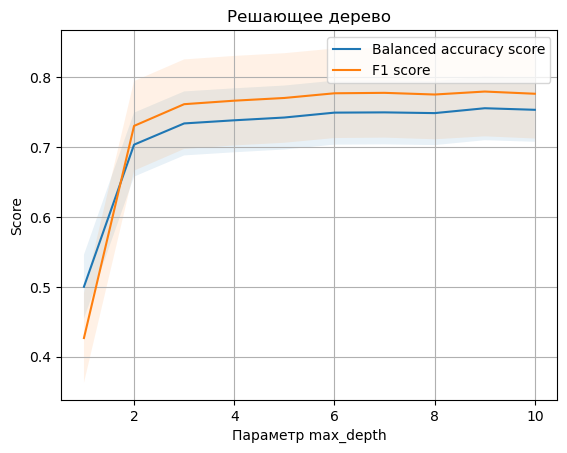

In [120]:
print(f"Лучший balanced_accuracy_score: {grid_search_dt_noPCA.best_score_}")

(X_plot, Y_plot_acc, Y_plot_f1s) = create_plot_data(grid_search_dt_noPCA, x_col="param_max_depth")

fig, ax = plt.subplots()

CI = 1.96 * np.std(Y_plot_acc)/np.sqrt(len(Y_plot_acc))
ax.plot(X_plot, Y_plot_acc, label='Balanced accuracy score')
ax.fill_between(X_plot, (Y_plot_acc-CI), (Y_plot_acc+CI), alpha=.1)

CI = 1.96 * np.std(Y_plot_f1s)/np.sqrt(len(Y_plot_f1s))
ax.plot(X_plot, Y_plot_f1s, label='F1 score')
ax.fill_between(X_plot, (Y_plot_f1s-CI), (Y_plot_f1s+CI), alpha=.1)

ax.set(xlabel='Параметр max_depth', ylabel='Score',
       title='Решающее дерево')
ax.grid()
ax.legend()

plt.show()

In [121]:
param_grid = {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #без None
             }

estimator = KNeighborsClassifier()
grid_search_kNN_noPCA = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_kNN_noPCA.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [122]:
kNN_basic = grid_search_kNN_noPCA.best_estimator_

Лучший balanced_accuracy_score: 0.7441417218422947


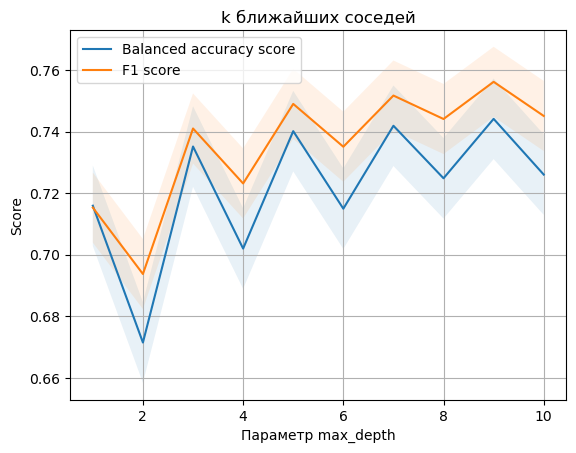

In [123]:
print(f"Лучший balanced_accuracy_score: {grid_search_kNN_noPCA.best_score_}")

(X_plot, Y_plot_acc, Y_plot_f1s) = create_plot_data(grid_search_kNN_noPCA, x_col="param_n_neighbors")

fig, ax = plt.subplots()

CI = 1.96 * np.std(Y_plot_acc)/np.sqrt(len(Y_plot_acc))
ax.plot(X_plot, Y_plot_acc, label='Balanced accuracy score')
ax.fill_between(X_plot, (Y_plot_acc-CI), (Y_plot_acc+CI), alpha=.1)

CI = 1.96 * np.std(Y_plot_f1s)/np.sqrt(len(Y_plot_f1s))
ax.plot(X_plot, Y_plot_f1s, label='F1 score')
ax.fill_between(X_plot, (Y_plot_f1s-CI), (Y_plot_f1s+CI), alpha=.1)

ax.set(xlabel='Параметр max_depth', ylabel='Score',
       title='k ближайших соседей')
ax.grid()
ax.legend()

plt.show()

## PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберите оптимальное количество компонент и преобразуйте данные. Объясните свой выбор.

In [124]:
pca_full = PCA(n_components=X_train.shape[1], svd_solver='full', random_state=RANDOM_STATE)
pca_full.fit(X_train)

PCA(n_components=56, random_state=9999, svd_solver='full')

Text(0, 0.5, 'Explained Variance (объясненное отклонение), ratio')

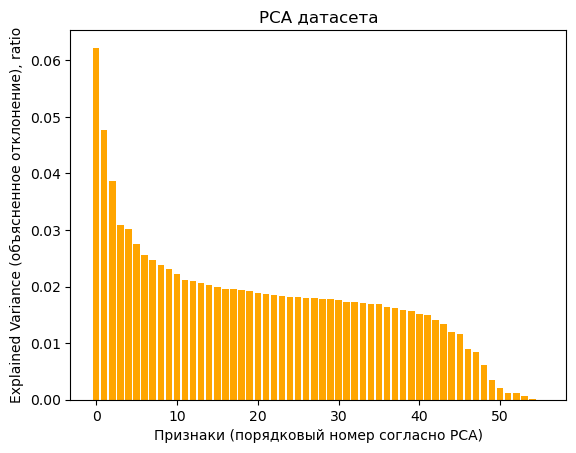

In [125]:
fig, ax = plt.subplots(1, 1)
res = pca_full.explained_variance_ratio_
ax.bar(list(range(0,len(res))), res, color='orange')
ax.set_title("PCA датасета")
ax.set_xlabel("Признаки (порядковый номер согласно PCA)")
ax.set_ylabel("Explained Variance (объясненное отклонение), ratio")

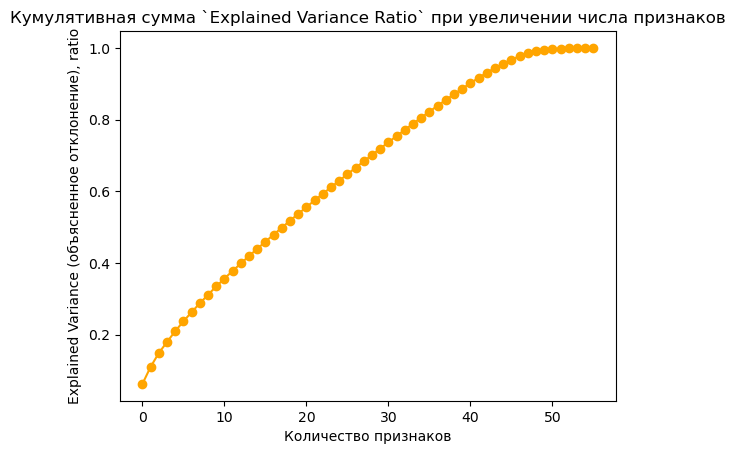

In [126]:
cumulative_variance_ratio = np.cumsum(res)
plt.plot(cumulative_variance_ratio, marker='o', color='orange')
plt.xlabel('Количество признаков')
plt.ylabel('Explained Variance (объясненное отклонение), ratio')
plt.title('Кумулятивная сумма `Explained Variance Ratio` при увеличении числа признаков')
plt.show()

In [127]:
pca = PCA(n_components=48, svd_solver='full', random_state=RANDOM_STATE) # Подобрал
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## Обучение классификаторов на данных, трансформированных с помощью PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберите оптимальные значения исследуемых гиперпараметров для новых данных. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

In [128]:
param_grid = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #без None
             }

estimator = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search_dt_withPCA = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_dt_withPCA.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=9999),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [129]:
dt_better = grid_search_dt_withPCA.best_estimator_

Лучший balanced_accuracy_score: 0.7465028597210224


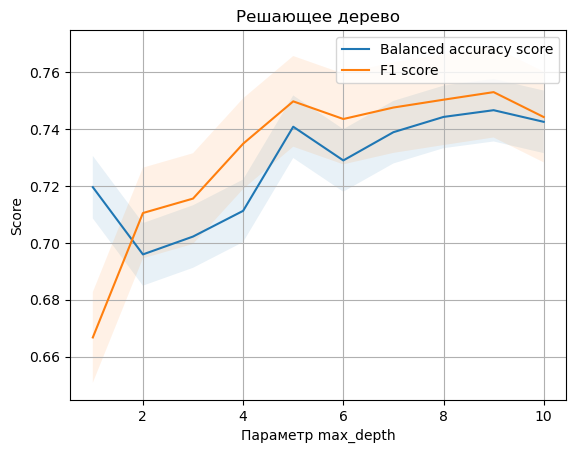

In [130]:
print(f"Лучший balanced_accuracy_score: {grid_search_dt_withPCA.best_score_}")

(X_plot, Y_plot_acc, Y_plot_f1s) = create_plot_data(grid_search_dt_withPCA, x_col="param_max_depth")

fig, ax = plt.subplots()

CI = 1.96 * np.std(Y_plot_acc)/np.sqrt(len(Y_plot_acc))
ax.plot(X_plot, Y_plot_acc, label='Balanced accuracy score')
ax.fill_between(X_plot, (Y_plot_acc-CI), (Y_plot_acc+CI), alpha=.1)

CI = 1.96 * np.std(Y_plot_f1s)/np.sqrt(len(Y_plot_f1s))
ax.plot(X_plot, Y_plot_f1s, label='F1 score')
ax.fill_between(X_plot, (Y_plot_f1s-CI), (Y_plot_f1s+CI), alpha=.1)

ax.set(xlabel='Параметр max_depth', ylabel='Score',
       title='Решающее дерево')
ax.grid()
ax.legend()

plt.show()

In [131]:
param_grid = {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #без None
             }

estimator = KNeighborsClassifier()
grid_search_kNN_withPCA = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_kNN_withPCA.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [132]:
kNN_better = grid_search_kNN_withPCA.best_estimator_

Лучший balanced_accuracy_score: 0.7438559883704154


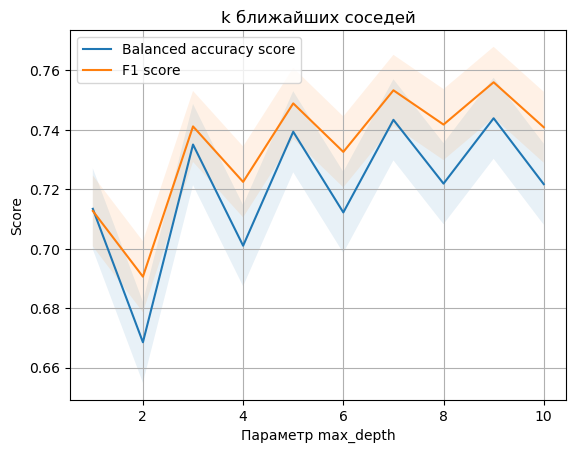

In [133]:
print(f"Лучший balanced_accuracy_score: {grid_search_kNN_withPCA.best_score_}")

(X_plot, Y_plot_acc, Y_plot_f1s) = create_plot_data(grid_search_kNN_withPCA, x_col="param_n_neighbors")

fig, ax = plt.subplots()

CI = 1.96 * np.std(Y_plot_acc)/np.sqrt(len(Y_plot_acc))
ax.plot(X_plot, Y_plot_acc, label='Balanced accuracy score')
ax.fill_between(X_plot, (Y_plot_acc-CI), (Y_plot_acc+CI), alpha=.1)

CI = 1.96 * np.std(Y_plot_f1s)/np.sqrt(len(Y_plot_f1s))
ax.plot(X_plot, Y_plot_f1s, label='F1 score')
ax.fill_between(X_plot, (Y_plot_f1s-CI), (Y_plot_f1s+CI), alpha=.1)

ax.set(xlabel='Параметр max_depth', ylabel='Score',
       title='k ближайших соседей')
ax.grid()
ax.legend()

plt.show()

## Сравнение результатов

Сравните результаты полученные до трансформации данных с помощью PCA и после. Есть ли изменения динамики среднего значения качества по кросс-валидации алгоритма? Объясните почему?

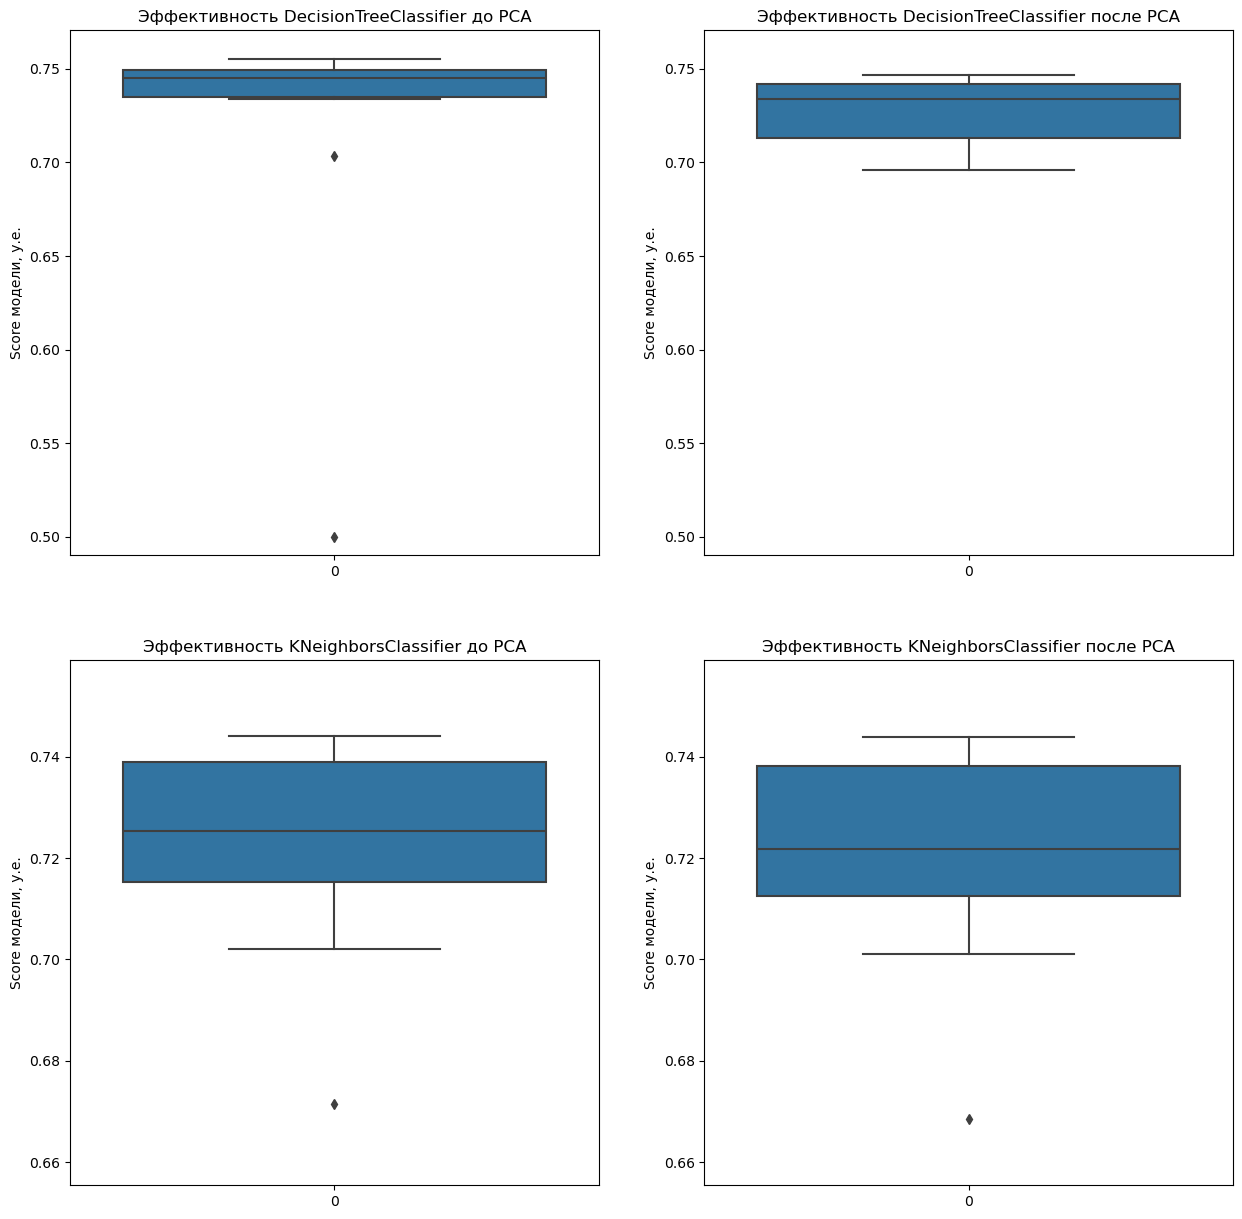

In [134]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
i = 0

pairs = {(grid_search_dt_noPCA, grid_search_dt_withPCA), (grid_search_kNN_noPCA, grid_search_kNN_withPCA)}

for GSCV in pairs:
    mts_cmn = GSCV[0].cv_results_["mean_test_balanced_accuracy"]
    mts_pca = GSCV[1].cv_results_["mean_test_balanced_accuracy"]

    # Для читаемости
    min = np.min(mts_cmn) if (np.min(mts_pca) > np.min(mts_cmn)) else np.min(mts_pca)
    max = np.max(mts_cmn) if (np.max(mts_pca) < np.max(mts_cmn)) else np.max(mts_pca)
    mul = 1.02
    min /= mul
    max *= mul

    sns.boxplot(data=mts_cmn, ax=ax[i, 0])
    ax[i, 0].set_title("Эффективность "+str(GSCV[0].best_estimator_.__class__.__name__)+" до PCA")
    ax[i, 0].set_ylabel("Score модели, у.е.")
    ax[i, 0].set(ylim=(min, max))

    sns.boxplot(data=mts_pca, ax=ax[i, 1])
    ax[i, 1].set_title("Эффективность "+str(GSCV[1].best_estimator_.__class__.__name__)+" после PCA")
    ax[i, 1].set_ylabel("Score модели, у.е.")
    ax[i, 1].set(ylim=(min, max))

    i+=1

## Тестирование всех модели

Протестируйте все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

In [135]:
# (гиперпараметры по умолчанию, оптимальные гиперпараметры, оптимальные гиперпараметры после PCA)
pairs = {(grid_search_dt_noPCA.best_estimator_, grid_search_dt_withPCA.best_estimator_), 
         (grid_search_kNN_noPCA.best_estimator_, grid_search_kNN_withPCA.best_estimator_)}

for estimators in pairs:
    print(f"Итоги для {estimators[0].__class__.__name__}")
    y_pred_basic = estimators[0].predict(X_test)
    f1_basic = f1_score(y_test, y_pred_basic)
    print(f"\tf1 score до PCA с гиперпараметрами по умолчанию: {f1_basic:.3f}")

    y_pred_better_pca = estimators[1].predict(X_test_pca)
    f1_pca = f1_score(y_test, y_pred_better_pca)
    print(f"\tКоэффициент детерминации после PCA с оптимальными гиперпараметрами: {f1_pca:.3f}")

    print('\n')
    

Итоги для DecisionTreeClassifier
	f1 score до PCA с гиперпараметрами по умолчанию: 0.623
	Коэффициент детерминации после PCA с оптимальными гиперпараметрами: 0.582


Итоги для KNeighborsClassifier
	f1 score до PCA с гиперпараметрами по умолчанию: 0.607
	Коэффициент детерминации после PCA с оптимальными гиперпараметрами: 0.603


